# Final size of a the simple epidemic model

The simple epidemic model is
$$\begin{aligned}
\frac{\mathrm{d} S}{\mathrm{d} t} &= - \beta S I,&
S(0) &= S_0 = N - I_0,\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta S I - \gamma I,&
I(0) &= I_0,\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma I,&
R(0) &= 0.
\end{aligned}$$

The basic reproduction number is
$$R_0 = \frac{\beta}{\gamma} S_0.$$

The model has
$$\frac{\mathrm{d} I}{\mathrm{d} t} =
\frac{\gamma I - \beta S I}{\beta S I} \frac{\mathrm{d} S}{\mathrm{d} t}.$$
For $I > 0$, this is
$$\frac{\mathrm{d} I}{\mathrm{d} t} =
\left(\frac{\gamma}{\beta S} - 1\right) \frac{\mathrm{d} S}{\mathrm{d} t},$$
so
$$I(t) - I(0) =
\frac{\gamma}{\beta} \left[\log S(t) - \log S(0)\right]
- S(t) + S(0).$$
Integrating with respect to $t$ gives
$$\log \frac{S(t)}{S_0}
= - R_0 \left[1 + \frac{I_0}{S_0} - \frac{S(t)}{S_0} - \frac{I(t)}{S_0}\right].$$

In the limit as $t \to +\infty$, $I(t) \to 0$, so
$$\log \frac{S_{\infty}}{S_0} = - R_0 \left[1 + \frac{I_0}{S_0} - \frac{S_{\infty}}{S_0}\right],$$
where $S_{\infty} = \lim_{t \to +\infty} S(t).$
Then
$$- R_0 \frac{S_{\infty}}{S_0} \mathrm{e}^{- R_0 \frac{S_{\infty}}{S_0}}
= - R_0 \mathrm{e}^{- R_0 \left(1 + \frac{I_0}{S_0}\right)},$$
Let $w = - R_0 \frac{S_{\infty}}{S_0}$
and $z = - R_0 \mathrm{e}^{- R_0 \left(1 + \frac{I_0}{S_0}\right)}$
so that
$$w \mathrm{e}^w = z,$$
then
$$w = \mathrm{W}(z),$$
where $\mathrm{W}(z)$ is the Lambert W function, or
$$- R_0 \frac{S_{\infty}}{S_0} 
= \mathrm{W}\left(- R_0 \mathrm{e}^{- R_0 \left(1 + \frac{I_0}{S_0}\right)}\right).$$
or
$$S_{\infty}
= - \frac{S_0}{R_0}
\mathrm{W}\left(- R_0 \mathrm{e}^{- R_0 \left(1 + \frac{I_0}{S_0}\right)}\right).$$

For the number recovered, $R_{\infty} = S_0 + I_0 - S_{\infty}$, so
$$R_{\infty}
= S_0 \left[1 + \frac{I_0}{S_0} + \frac{1}{R_0}
\mathrm{W}\left(- R_0 \mathrm{e}^{- R_0 \left(1 + \frac{I_0}{S_0}\right)}\right)\right].$$

In the limit as $I_0 \to 0$,
$$R_{\infty} = \begin{cases}
0 & \text{if $R_0 \leq 1$},\\
S_0 \left[1 + \frac{1}{R_0} \mathrm{W}(- R_0 \mathrm{e}^{- R_0})\right] & \text{if $R_0 > 1$}.
\end{cases}$$

Let's assume
$$\begin{aligned}
\beta &\sim \Gamma(0.03, 4),\\
\gamma &\sim \Gamma(0.01, 4),\\
S_0 &= N = 1.
\end{aligned}$$

In [45]:
from matplotlib import pyplot
import numpy
import pandas
from scipy import special
from scipy import stats
import seaborn
import statsmodels.api

import sensitivity_analysis


numpy.random.seed(1)


def model(beta, gamma, S_0=1, I_0=0):
    '''The final size $R_{\infty}$ for a simple SIR model.'''
    R_0 = beta * S_0 / gamma
    W = special.lambertw(- R_0 * numpy.exp(- R_0 * (1 + I_0 / S_0)))
    R_inf = numpy.real_if_close(S_0 * (1 + I_0 / S_0 + W / R_0))
    return numpy.where((I_0 == 0) & (R_0 <= 1), 0, R_inf)


# Let the transmission rate be a Gamma random variable.
transmission_rate_mean = 0.03
transmission_rate_shape = 4
transmission_rate_scale = transmission_rate_mean / transmission_rate_shape
transmission_rate = stats.gamma(transmission_rate_shape,
                                scale=transmission_rate_scale)

# Let the recovery rate be a Gamma random variable.
recovery_rate_mean = 0.01
recovery_rate_shape = 4
recovery_rate_scale = recovery_rate_mean / recovery_rate_shape
recovery_rate = stats.gamma(recovery_rate_shape,
                            scale=recovery_rate_scale)

parameters = dict(beta=transmission_rate,
                  gamma=recovery_rate)

# Uncertainty analysis

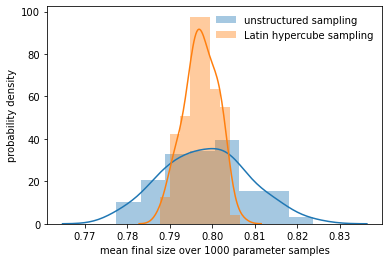

In [2]:
def get_mean(model, parameters, n_samples,
             sampler=sensitivity_analysis.samples_Latin_hypercube):
    X = sampler(parameters, n_samples)
    y = model(**X)
    return numpy.mean(y)


n_samples = 1000
n_runs = 100
means = [get_mean(model, parameters, n_samples,
                  sampler=sensitivity_analysis.samples_unstructured)
         for _ in range(n_runs)]
means_LHS = [get_mean(model, parameters, n_samples,
                      sampler=sensitivity_analysis.samples_Latin_hypercube)
             for _ in range(n_runs)]

seaborn.distplot(means, label='unstructured sampling')
seaborn.distplot(means_LHS, label='Latin hypercube sampling')
pyplot.xlabel(f'mean final size over {n_samples} parameter samples')
pyplot.ylabel('probability density')
_ = pyplot.legend()

In [3]:
n_samples = [10, 20, 50,
             100, 200, 500,
             1000, 2000, 5000,
             10000]
n_runs = 100
means = pandas.DataFrame({n: [get_mean(model, parameters, n)
                              for _ in range(n_runs)]
                          for n in n_samples})
means.rename_axis(columns='model evaluations', inplace=True)

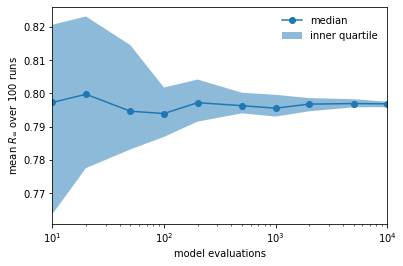

In [8]:
def plot_median_and_quartiles(df):
    ax = df.median().plot(label='median', marker='o', logx=True)
    ax.fill_between(df.columns, df.quantile(0.25), df.quantile(0.75),
                    label='inner quartile', alpha=0.5)
    ax.legend()
    return ax


ax = plot_median_and_quartiles(means)
_ = ax.set_ylabel(f'mean $R_{{\infty}}$ over {n_runs} runs')

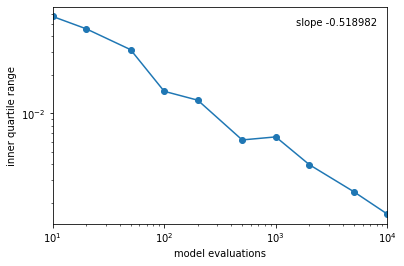

In [5]:
def IQR(x):
    return x.quantile(0.75) - x.quantile(0.25)


def estimate_slope_loglog(ser):
    '''Estimate b so that y = a x ^ b'''
    X = statsmodels.api.add_constant(numpy.log10(ser.index))
    y = numpy.log10(ser)
    lm = statsmodels.api.OLS(y, X).fit()
    return lm.params[1]


def plot_IQR(df):
    iqr = IQR(df)
    ax = iqr.plot(marker='o', logx=True, logy=True)
    ax.set_ylabel('inner quartile range')
    slope = estimate_slope_loglog(iqr)
    ax.annotate(f'slope {slope:g}', (0.97, 0.95),
                horizontalalignment='right',
                verticalalignment='top',
                xycoords='axes fraction')
    return ax


ax = plot_IQR(means)

# Sensitivity analysis

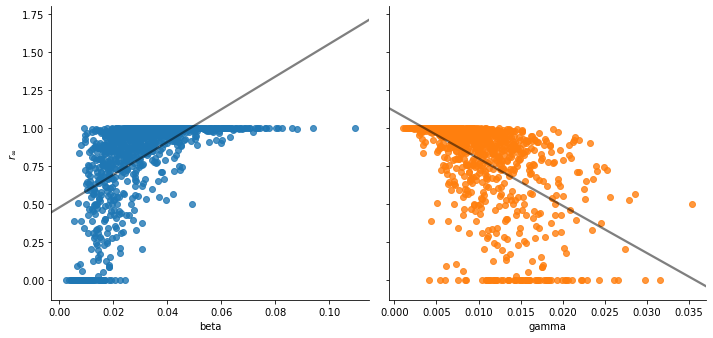

In [9]:
fg = sensitivity_analysis.scatterplots(model, parameters, n_samples=1000)
_ = fg.set_ylabels(r'$r_{\infty}$')

In [10]:
def bold_sum(s):
    '''Made the 'Sum' row bold.'''
    is_sum = (s.index == 'Sum')
    return ['font-weight: bold' if v else '' for v in is_sum]


def display_with_sums(table):
    '''Add column sums and display.'''
    table = table.copy()
    table.loc['Sum'] = table.sum()
    return table.style.apply(bold_sum)


n_samples = 1000
table = {}
# table[r'$S$'] = sensitivity_analysis.sensitivity(
#     model, parameters, n_samples, normalized=False)
# table[r'$\beta$'] = sensitivity_analysis.linreg_coefficients(
#     model, parameters, n_samples, normalized=False)
# table[r'$\nu$'] = sensitivity_analysis.DGSM(
#     model, parameters, n_samples, normalized=False)
table[r'$S_{\sigma}$'] = sensitivity_analysis.sensitivity(
    model, parameters, n_samples)
table[r'$\beta_{\sigma}$'] = sensitivity_analysis.linreg_coefficients(
    model, parameters, n_samples)
table[r'$\nu_{\sigma}$'] = sensitivity_analysis.DGSM(
    model, parameters, n_samples)
(S, _, S_T, _) = sensitivity_analysis.Sobol_indexes(
    model, parameters, n_samples)
table[r'$S$'] = S
table[r'$S_{\text{T}}$'] = S_T
table[r'$\rho_{\text{partial rank}}$'] = sensitivity_analysis.PRCC(
    model, parameters, n_samples)
table = pandas.DataFrame(table)
display_with_sums(table)

,$S_{\sigma}$,$\beta_{\sigma}$,$\nu_{\sigma}$,$S$,$S_{\text{T}}$,$\rho_{\text{partial rank}}$
beta,0.362911,0.542052,3.28992,0.538483,0.623999,0.945706
gamma,-0.358367,-0.56378,0.694896,0.356527,0.50607,-0.945293
Sum,0.00454456,-0.0217275,3.98481,0.89501,1.13007,0.000412553


In [11]:
def display_Sobol_indexes(S, S_PE, S_T, S_T_PE, alpha=0.5):
    '''Display the Sobol' indexes S and S_T in a nice table.'''
    table = pandas.concat((S, S_PE, S_T, S_T_PE), axis='columns')
    CI_percent = 100 * (1 - alpha)
    columns = pandas.MultiIndex.from_product(
        (('First-order index ($S$)', r'Total-order index ($S_{\text{T}}$)'),
         ('Estimate', f'{CI_percent:g}% probable error')))
    table.set_axis(columns, axis='columns', inplace=True)
    table.loc['Sum'] = table.sum()
    # Don't show the sum of the probable errors.
    estimates = (columns.get_level_values(1) == 'Estimate')
    table.loc['Sum', ~estimates] = ''
    display(table.style.apply(bold_sum))


n_samples = 1000
alpha = 0.5
(S, S_PE, S_T, S_T_PE) = sensitivity_analysis.Sobol_indexes(
    model, parameters, n_samples, alpha=alpha)
display_Sobol_indexes(S, S_PE, S_T, S_T_PE, alpha=alpha)

# Problem

Plots the accuracy of the sensitivity measures vs. the number of model evaluations. Do this for:
* $S_{\sigma}$, the sigma-normalized sensitivity;
* $\beta_{\sigma}$, the sigma-normalized regression coefficients;
* maybe $v_{\sigma}$, the sigma-normalized DGSM;
* $S$, the first-order Sobol' index;
* $S_{\text{T}}$, the total-order Sobol' index; and
* maybe $\rho_{\text{partial rank}}$, the partial rank correlation coefficient.

(Should we use the squared $S_{\sigma}$ and $\beta_{\sigma}$ instead?)

What should we use to measure the error?
* the norm of the covariance matrix of the vector of sensitivities over many resamples.
(Should there be a square root somewhere?)

For $n$ samples of $k$ parameters:
* $S_{\sigma}$ needs $n + k + 1$ model evaluations;
* $\beta_{\sigma}$ needs $n$ model evaluations;
* $\nu_{\sigma}$ needs $(k + 1) n$ model evaluations;
* $S$ and $S_{\text{T}}$ together need $(k + 2) n$ model evaluations; and
* $\rho_{\text{partial rank}}$ needs $n$ model evaluations.

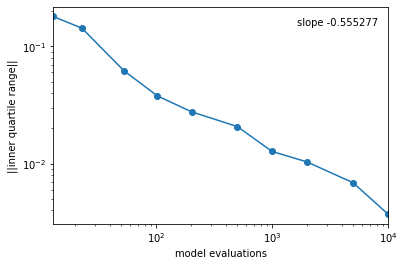

In [12]:
def do_runs(fcn, model, parameters, n_samples, n_runs):
    return pandas.DataFrame([fcn(model, parameters, n_samples)
                             for _ in range(n_runs)])


def do_sample_levels(fcn, model, parameters, n_samples, n_runs, model_evals):
    return pandas.concat({model_evals(n): do_runs(fcn, model, parameters, n, n_runs)
                          for n in n_samples},
                         axis='columns', names=['model evaluations', 'parameter'])


def IQR_norm(df, ord=2):
    '''The norm of the inner quartile range of the rows of data.'''
    iqr = IQR(df).unstack()
    return iqr.apply(numpy.linalg.norm, axis='columns', ord=ord)


def plot_IQR_norm(df, ax=None, show_slope=True, ord=2):
    norm = IQR_norm(df, ord=ord)
    ax = norm.plot(marker='o', ax=ax, logx=True, logy=True)
    ax.set_ylabel('||inner quartile range||')
    slope = estimate_slope_loglog(norm)
    if show_slope:
        ax.annotate(f'slope {slope:g}', (0.97, 0.95),
                    horizontalalignment='right',
                    verticalalignment='top',
                    xycoords='axes fraction')
    return ax


n_samples = [10, 20, 50,
             100, 200, 500,
             1000, 2000, 5000,
             10000]
n_runs = 100
model_evals = lambda n_samples: n_samples + len(parameters) + 1
S_sigma = do_sample_levels(
    sensitivity_analysis.sensitivity, model, parameters, n_samples, n_runs, model_evals)
ax = plot_IQR_norm(S_sigma)

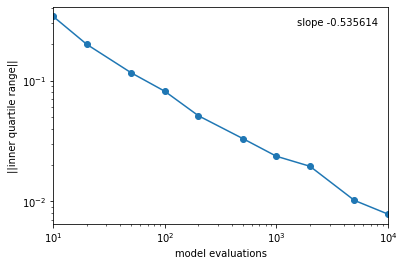

In [13]:
model_evals = lambda n_samples: n_samples
beta_sigma = do_sample_levels(
    sensitivity_analysis.linreg_coefficients, model, parameters, n_samples, n_runs, model_evals)
ax = plot_IQR_norm(beta_sigma)

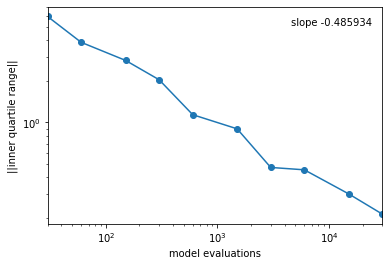

In [40]:
model_evals = lambda n_samples: (len(parameters) + 1) * n_samples
nu_sigma = do_sample_levels(
    sensitivity_analysis.DGSM, model, parameters, n_samples, n_runs, model_evals)
ax = plot_IQR_norm(nu_sigma)

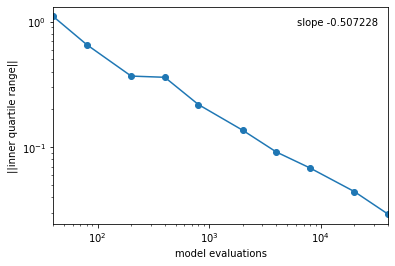

In [15]:
def get_S(model, parameters, n_samples):
    (S, _, _, _) = sensitivity_analysis.Sobol_indexes(model, parameters, n_samples)
    return S


model_evals = lambda n_samples: (len(parameters) + 2) * n_samples
S = do_sample_levels(
    get_S, model, parameters, n_samples, n_runs, model_evals)
ax = plot_IQR_norm(S)

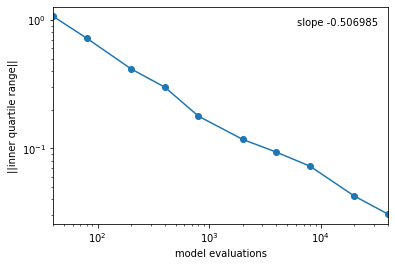

In [16]:
def get_S_T(model, parameters, n_samples):
    (_, _, S_T, _) = sensitivity_analysis.Sobol_indexes(model, parameters, n_samples)
    return S_T


model_evals = lambda n_samples: (len(parameters) + 2) * n_samples
S_T = do_sample_levels(
    get_S_T, model, parameters, n_samples, n_runs, model_evals)
ax = plot_IQR_norm(S_T)

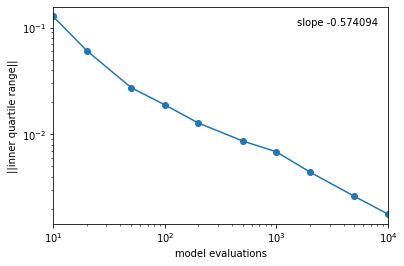

In [17]:
model_evals = lambda n_samples: n_samples
prcc = do_sample_levels(
    sensitivity_analysis.PRCC, model, parameters, n_samples, n_runs, model_evals)
ax = plot_IQR_norm(prcc)

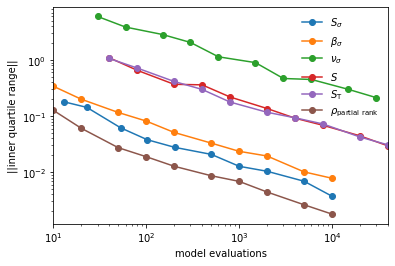

In [41]:
(fig, ax) = pyplot.subplots()
labels = []
plot_IQR_norm(S_sigma, show_slope=False, ax=ax)
labels.append(r'$S_{\sigma}$')
plot_IQR_norm(beta_sigma, show_slope=False, ax=ax)
labels.append(r'$\beta_{\sigma}$')
plot_IQR_norm(nu_sigma, show_slope=False, ax=ax)
labels.append(r'$\nu_{\sigma}$')
plot_IQR_norm(S, show_slope=False, ax=ax)
labels.append(r'$S$')
plot_IQR_norm(S_T, show_slope=False, ax=ax)
labels.append(r'$S_{\mathrm{T}}$')
plot_IQR_norm(prcc, show_slope=False, ax=ax)
labels.append(r'$\rho_{\mathrm{partial\ rank}}$')
_ = ax.legend(labels)

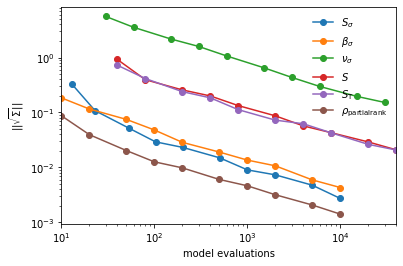

In [42]:
def cov_norm(df, ord=2):
    '''The norm of the covariance matrix.'''
    return numpy.sqrt(numpy.linalg.norm(numpy.cov(df, rowvar=False), ord=ord))


def plot_cov_norm(df, ax=None, show_slope=True, ord=2):
    by = 'model evaluations'
    norm = df.stack(by).groupby(by).apply(cov_norm, ord=ord)
    ax = norm.plot(marker='o', ax=ax, logx=True, logy=True)
    ax.set_ylabel(r'$||\sqrt{\Sigma}\||$')
    slope = estimate_slope_loglog(norm)
    if show_slope:
        ax.annotate(f'slope {slope:g}', (0.97, 0.95),
                    horizontalalignment='right',
                    verticalalignment='top',
                    xycoords='axes fraction')
    return ax


(fig, ax) = pyplot.subplots()
labels = []
plot_cov_norm(S_sigma, show_slope=False, ax=ax)
labels.append(r'$S_{\sigma}$')
plot_cov_norm(beta_sigma, show_slope=False, ax=ax)
labels.append(r'$\beta_{\sigma}$')
plot_cov_norm(nu_sigma, show_slope=False, ax=ax)
labels.append(r'$\nu_{\sigma}$')
plot_cov_norm(S, show_slope=False, ax=ax)
labels.append(r'$S$')
plot_cov_norm(S_T, show_slope=False, ax=ax)
labels.append(r'$S_{\mathrm{T}}$')
plot_cov_norm(prcc, show_slope=False, ax=ax)
labels.append(r'$\rho_{\mathrm{partial rank}}$')
_ = ax.legend(labels)

## Accuracy vs. number of parmeters

Adding $k$ non-influential parameters $Z_0, ..., Z_{k - 1}$,
the model is
$$\hat{R}_{\infty}(\beta, \gamma, Z_0, ..., Z_{k - 1}) = R_{\infty}(\beta, \gamma)$$

# Conclusions

If runs are expensive or the number of parameters is large, $\rho_{\text{partial rank}}$ and $\beta_{\sigma}$ are preferred for using fewer model evaluations and can even be simultaneously computed from the same samples.

If runs are cheap, $S$ and $S_T$ are preferred.

The error on $\nu_{\sigma}$ is expensive to compute and the variation is large.